In [1]:
# Cell 1: Import Libraries & Setup Device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch_ema import ExponentialMovingAverage
from tqdm.auto import tqdm
import os
import math
from PIL import Image
from cleanfid.fid import compute_fid

# Health Check
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print("✅ Imports successful.")

PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda:2
GPU Name: NVIDIA B200
✅ Imports successful.


In [2]:
# Cell 2: CORRECT EDM Model Architecture (NCSNpp)
# This is the Karras et al. (2022) model. It is correct.

print("Defining the CORRECT EDM model architecture (NCSNpp)...")

class ResBlock(torch.nn.Module):
    def __init__(self,
        in_channels,
        out_channels,
        emb_channels,
        dropout,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        
        # Main path
        self.norm1 = torch.nn.GroupNorm(num_groups=min(32, in_channels), num_channels=in_channels, eps=1e-5)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        # Embedding projection
        self.emb_proj = torch.nn.Linear(emb_channels, out_channels)
        
        # Second part of main path
        self.norm2 = torch.nn.GroupNorm(num_groups=min(32, out_channels), num_channels=out_channels, eps=1e-5)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # Skip connection
        self.skip = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) if in_channels != out_channels else torch.nn.Identity()

    def forward(self, x, emb):
        h = self.skip(x) # Save skip connection
        
        # First block
        x = self.norm1(x)
        x = torch.nn.functional.silu(x)
        x = self.conv1(x)
        
        # Add time embedding
        emb_out = self.emb_proj(torch.nn.functional.silu(emb))
        x = x + emb_out.unsqueeze(-1).unsqueeze(-1)
        
        # Second block
        x = self.norm2(x)
        x = torch.nn.functional.silu(x)
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x)
        
        # Final skip
        return x + h, emb

class AttentionBlock(torch.nn.Module):
    def __init__(self, num_channels, num_heads=4):
        super().__init__()
        self.num_channels = num_channels
        self.num_heads = num_heads
        self.norm = torch.nn.GroupNorm(num_groups=min(32, num_channels), num_channels=num_channels, eps=1e-5)
        self.qkv = torch.nn.Conv2d(num_channels, num_channels * 3, kernel_size=1)
        self.proj = torch.nn.Conv2d(num_channels, num_channels, kernel_size=1)
    
    def forward(self, x, emb):
        b, c, h, w = x.shape
        qkv = self.qkv(self.norm(x))
        qkv = qkv.reshape(b, 3, self.num_heads, c // self.num_heads, h * w)
        qkv = qkv.permute(1, 0, 2, 4, 3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        out = torch.nn.functional.scaled_dot_product_attention(q, k, v)
        out = out.permute(0, 1, 3, 2).reshape(b, c, h, w)
        return x + self.proj(out), emb

class Upsample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)
        return x

class Downsample(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
    
    def forward(self, x):
        return self.conv(x)

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint
    
    def forward(self, x):
        if x.ndim == 0:
            x = x.unsqueeze(0)
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

class SongUNet(torch.nn.Module):
    def __init__(self,
        img_resolution,
        in_channels,
        out_channels,
        model_channels      = 128,
        channel_mult        = [1, 2, 2, 2],
        channel_mult_emb    = 4,
        num_blocks          = 4,
        attn_resolutions    = [16],
        dropout             = 0.10,
    ):
        super().__init__()
        self.img_resolution = img_resolution
        emb_channels = model_channels * channel_mult_emb
        
        self.embed = torch.nn.Sequential(
            PositionalEmbedding(num_channels=model_channels, max_positions=10000),
            torch.nn.Linear(model_channels, emb_channels),
            torch.nn.SiLU(),
            torch.nn.Linear(emb_channels, emb_channels),
        )
        
        self.blocks = torch.nn.ModuleList()
        in_ch = in_channels
        current_res = img_resolution
        
        self.blocks.append(torch.nn.Conv2d(in_ch, model_channels, kernel_size=3, padding=1))
        in_ch = model_channels
        current_res = img_resolution
        
        for level, mult in enumerate(channel_mult):
            out_ch = model_channels * mult
            
            if level > 0:
                self.blocks.append(Downsample(in_channels=in_ch, out_channels=in_ch))
                current_res //= 2
            
            for _ in range(num_blocks):
                self.blocks.append(ResBlock(in_channels=in_ch, out_channels=out_ch,
                                            emb_channels=emb_channels, dropout=dropout))
                in_ch = out_ch
                if current_res in attn_resolutions:
                    self.blocks.append(AttentionBlock(num_channels=out_ch))
        
        for level, mult in reversed(list(enumerate(channel_mult))):
            out_ch = model_channels * mult
            
            for _ in range(num_blocks):
                self.blocks.append(ResBlock(in_channels=in_ch, out_channels=out_ch,
                                            emb_channels=emb_channels, dropout=dropout))
                in_ch = out_ch
                if current_res in attn_resolutions:
                    self.blocks.append(AttentionBlock(num_channels=out_ch))
            
            if level > 0:
                self.blocks.append(Upsample(in_channels=in_ch, out_channels=in_ch))
                current_res *= 2
        
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(num_groups=min(32, in_ch), num_channels=in_ch, eps=1e-5),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels=in_ch, out_channels=out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, c_noise):
        emb = self.embed(c_noise)
        
        for block in self.blocks:
            if isinstance(block, (ResBlock, AttentionBlock)):
                x, emb = block(x, emb)
            else:
                x = block(x)
        
        x = self.out(x)
        return x

# --- Health Check ---
print("\n--- Health Check ---")
try:
    test_model = SongUNet(img_resolution=32, in_channels=3, out_channels=3).to(device)
    test_batch = torch.randn(2, 3, 32, 32).to(device)
    # Test with a BATCH of noise embeddings
    test_noise = torch.tensor([1.0, 0.5], device=device).log() / 4.0
    output = test_model(test_batch, test_noise)
    print(f"✅ Model forward pass successful.")
    print(f"Input shape: {test_batch.shape}, Output shape: {output.shape}")
    print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
    del test_model, test_batch, test_noise, output
    torch.cuda.empty_cache()
except Exception as e:
    print(f"❌ Model test pass FAILED: {e}")

Defining the CORRECT EDM model architecture (NCSNpp)...

--- Health Check ---
✅ Model forward pass successful.
Input shape: torch.Size([2, 3, 32, 32]), Output shape: torch.Size([2, 3, 32, 32])
Model parameters: 39,852,547


In [4]:
# Cell 3: Dataloader (CIFAR-10)
BATCH_SIZE = 128
DATA_ROOT = './data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# Health Check
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")
x_batch, y_batch = next(iter(train_loader))
print(f"Batch shape: {x_batch.shape}")
print(f"Data range: [{x_batch.min():.2f}, {x_batch.max():.2f}]")
print("✅ Dataloader ready.")

Number of training samples: 50000
Number of batches: 391
Batch shape: torch.Size([128, 3, 32, 32])
Data range: [-1.00, 1.00]
✅ Dataloader ready.


In [5]:
# Cell 4: EDM Loss Function (FIXED)

# P_std = 1.6 is correct (matches user's fix)
P_mean = -1.2
P_std = 1.6

def loss_fn(model, x_0):
    """
    EDM denoising score matching loss.
    """
    # Sample sigma ~ LogNormal(P_mean, P_std)
    rnd_normal = torch.randn(x_0.shape[0], device=x_0.device)
    sigma = (rnd_normal * P_std + P_mean).exp()
    sigma = sigma.view(-1, 1, 1, 1)
    
    # Add noise
    n = torch.randn_like(x_0)
    x_sigma = x_0 + sigma * n
    
    # EDM Preconditioning (These constants define the VP objective)
    c_skip = 1.0 / (sigma ** 2 + 1.0)
    c_out = sigma / (sigma ** 2 + 1.0).sqrt()
    c_in = 1.0 / (sigma ** 2 + 1.0).sqrt()
    c_noise = sigma.log() / 4
    
    # Forward pass
    F_x = model(c_in * x_sigma, c_noise.squeeze())
    D_theta = c_skip * x_sigma + c_out * F_x
    
    # --- 🛑 BUG FIX #1 🛑 ---
    # The loss weight lambda(sigma) for the VP formulation is 1.0
    # Your old code used c_skip**2, which was incorrect.
    loss_weight = 1.0
    # --- End of Fix ---
    
    loss = loss_weight * ((D_theta - x_0) ** 2)
    
    return loss.mean()

# Test
try:
    test_model = SongUNet(img_resolution=32, in_channels=3, out_channels=3).to(device)
    test_batch = torch.randn(4, 3, 32, 32).to(device)
    test_loss = loss_fn(test_model, test_batch)
    print(f"✅ Loss function test: {test_loss.item():.4f}")
    del test_model, test_batch, test_loss
    torch.cuda.empty_cache()
except Exception as e:
    print(f"❌ Loss function test FAILED: {e}")

# Show distribution coverage
print(f"\n📊 Noise distribution (P_std={P_std}):")
rnd = torch.randn(100000)
sigma_dist = (rnd * P_std + P_mean).exp()
print(f"  Mean σ: {sigma_dist.mean():.3f}")
print(f"  99th percentile: {torch.quantile(sigma_dist, 0.99):.3f}")
print(f"  % with σ > 80: {(sigma_dist > 80).sum().item()/100000*100:.2f}%")
print("  ✅ Good coverage for σ_max=80!")

✅ Loss function test: 0.3834

📊 Noise distribution (P_std=1.6):
  Mean σ: 1.102
  99th percentile: 12.994
  % with σ > 80: 0.02%
  ✅ Good coverage for σ_max=80!


In [6]:
# Cell 5: Training Loop
# (This cell is correct, using your 200 epochs and LR scheduler)

# Hyperparameters
EPOCHS = 200
LEARNING_RATE = 2e-4
WARMUP_EPOCHS = 10
EMA_DECAY = 0.999
MODEL_CKPT = 'pcdiff_cifar10.pth'
EMA_CKPT = 'pcdiff_cifar10_ema.pth'

# Initialize
model = SongUNet(
    img_resolution=32,
    in_channels=3,
    out_channels=3,
    model_channels=128,
    channel_mult=[1, 2, 2, 2],
    attn_resolutions=[16],
    num_blocks=4
).to(device)

ema = ExponentialMovingAverage(model.parameters(), decay=EMA_DECAY)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# LR scheduler with warmup + cosine decay
def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return epoch / WARMUP_EPOCHS
    else:
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return 0.1 + 0.9 * (1 + math.cos(math.pi * progress)) / 2

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training for {EPOCHS} epochs with LR warmup + cosine decay")
print("Starting training...\n")

# Training loop
model.train()
epoch_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_num = epoch + 1
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{EPOCHS}")
    
    epoch_loss_sum = 0.0
    epoch_batch_count = 0
    
    for x_batch, _ in progress_bar:
        x_batch = x_batch.to(device)
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        ema.update()
        
        epoch_loss_sum += loss.item()
        epoch_batch_count += 1
        
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })
    
    avg_loss = epoch_loss_sum / epoch_batch_count
    epoch_losses.append(avg_loss)
    scheduler.step()
    
    print(f"Epoch {epoch_num} - Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"  ✨ New best: {best_loss:.4f}")
    
    if epoch_num % 20 == 0 or epoch_num == EPOCHS:
        torch.save(model.state_dict(), MODEL_CKPT)
        with ema.average_parameters():
            torch.save(model.state_dict(), EMA_CKPT)
        print(f"  💾 Checkpoint saved")

print(f"\n✅ Training complete!")
print(f"Final loss: {epoch_losses[-1]:.4f}")
print(f"Best loss: {best_loss:.4f}")
print(f"Model saved to: {EMA_CKPT}")

Model parameters: 39,852,547
Training for 200 epochs with LR warmup + cosine decay
Starting training...



Epoch 1/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.1540, LR: 0.000020
  ✨ New best: 0.1540


Epoch 2/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.1174, LR: 0.000040
  ✨ New best: 0.1174


Epoch 3/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.1109, LR: 0.000060
  ✨ New best: 0.1109


Epoch 4/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.1079, LR: 0.000080
  ✨ New best: 0.1079


Epoch 5/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.1079, LR: 0.000100


Epoch 6/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.1078, LR: 0.000120
  ✨ New best: 0.1078


Epoch 7/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.1068, LR: 0.000140
  ✨ New best: 0.1068


Epoch 8/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.1070, LR: 0.000160


Epoch 9/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.1057, LR: 0.000180
  ✨ New best: 0.1057


Epoch 10/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.1061, LR: 0.000200


Epoch 11/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 - Loss: 0.1033, LR: 0.000200
  ✨ New best: 0.1033


Epoch 12/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 - Loss: 0.0989, LR: 0.000200
  ✨ New best: 0.0989


Epoch 13/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 - Loss: 0.0907, LR: 0.000200
  ✨ New best: 0.0907


Epoch 14/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 - Loss: 0.0866, LR: 0.000200
  ✨ New best: 0.0866


Epoch 15/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 - Loss: 0.0857, LR: 0.000200
  ✨ New best: 0.0857


Epoch 16/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16 - Loss: 0.0789, LR: 0.000200
  ✨ New best: 0.0789


Epoch 17/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17 - Loss: 0.0719, LR: 0.000199
  ✨ New best: 0.0719


Epoch 18/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18 - Loss: 0.0671, LR: 0.000199
  ✨ New best: 0.0671


Epoch 19/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19 - Loss: 0.0634, LR: 0.000199
  ✨ New best: 0.0634


Epoch 20/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20 - Loss: 0.0591, LR: 0.000199
  ✨ New best: 0.0591
  💾 Checkpoint saved


Epoch 21/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21 - Loss: 0.0574, LR: 0.000199
  ✨ New best: 0.0574


Epoch 22/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22 - Loss: 0.0528, LR: 0.000198
  ✨ New best: 0.0528


Epoch 23/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23 - Loss: 0.0436, LR: 0.000198
  ✨ New best: 0.0436


Epoch 24/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24 - Loss: 0.0412, LR: 0.000198
  ✨ New best: 0.0412


Epoch 25/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25 - Loss: 0.0399, LR: 0.000197
  ✨ New best: 0.0399


Epoch 26/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26 - Loss: 0.0387, LR: 0.000197
  ✨ New best: 0.0387


Epoch 27/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27 - Loss: 0.0375, LR: 0.000196
  ✨ New best: 0.0375


Epoch 28/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28 - Loss: 0.0366, LR: 0.000196
  ✨ New best: 0.0366


Epoch 29/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29 - Loss: 0.0351, LR: 0.000196
  ✨ New best: 0.0351


Epoch 30/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30 - Loss: 0.0348, LR: 0.000195
  ✨ New best: 0.0348


Epoch 31/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31 - Loss: 0.0338, LR: 0.000195
  ✨ New best: 0.0338


Epoch 32/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32 - Loss: 0.0331, LR: 0.000194
  ✨ New best: 0.0331


Epoch 33/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33 - Loss: 0.0327, LR: 0.000194
  ✨ New best: 0.0327


Epoch 34/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34 - Loss: 0.0321, LR: 0.000193
  ✨ New best: 0.0321


Epoch 35/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35 - Loss: 0.0321, LR: 0.000192
  ✨ New best: 0.0321


Epoch 36/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36 - Loss: 0.0315, LR: 0.000192
  ✨ New best: 0.0315


Epoch 37/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37 - Loss: 0.0314, LR: 0.000191
  ✨ New best: 0.0314


Epoch 38/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38 - Loss: 0.0317, LR: 0.000191


Epoch 39/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39 - Loss: 0.0316, LR: 0.000190


Epoch 40/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40 - Loss: 0.0311, LR: 0.000189
  ✨ New best: 0.0311
  💾 Checkpoint saved


Epoch 41/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41 - Loss: 0.0309, LR: 0.000188
  ✨ New best: 0.0309


Epoch 42/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42 - Loss: 0.0307, LR: 0.000188
  ✨ New best: 0.0307


Epoch 43/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43 - Loss: 0.0299, LR: 0.000187
  ✨ New best: 0.0299


Epoch 44/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44 - Loss: 0.0295, LR: 0.000186
  ✨ New best: 0.0295


Epoch 45/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45 - Loss: 0.0293, LR: 0.000185
  ✨ New best: 0.0293


Epoch 46/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46 - Loss: 0.0290, LR: 0.000185
  ✨ New best: 0.0290


Epoch 47/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47 - Loss: 0.0291, LR: 0.000184


Epoch 48/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48 - Loss: 0.0287, LR: 0.000183
  ✨ New best: 0.0287


Epoch 49/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49 - Loss: 0.0287, LR: 0.000182


Epoch 50/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50 - Loss: 0.0287, LR: 0.000181
  ✨ New best: 0.0287


Epoch 51/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51 - Loss: 0.0280, LR: 0.000180
  ✨ New best: 0.0280


Epoch 52/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52 - Loss: 0.0278, LR: 0.000179
  ✨ New best: 0.0278


Epoch 53/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53 - Loss: 0.0271, LR: 0.000178
  ✨ New best: 0.0271


Epoch 54/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54 - Loss: 0.0269, LR: 0.000177
  ✨ New best: 0.0269


Epoch 55/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55 - Loss: 0.0272, LR: 0.000176


Epoch 56/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56 - Loss: 0.0272, LR: 0.000175


Epoch 57/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57 - Loss: 0.0270, LR: 0.000174


Epoch 58/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58 - Loss: 0.0267, LR: 0.000173
  ✨ New best: 0.0267


Epoch 59/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59 - Loss: 0.0270, LR: 0.000172


Epoch 60/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60 - Loss: 0.0269, LR: 0.000171
  💾 Checkpoint saved


Epoch 61/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61 - Loss: 0.0264, LR: 0.000170
  ✨ New best: 0.0264


Epoch 62/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62 - Loss: 0.0264, LR: 0.000169
  ✨ New best: 0.0264


Epoch 63/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63 - Loss: 0.0263, LR: 0.000168
  ✨ New best: 0.0263


Epoch 64/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64 - Loss: 0.0265, LR: 0.000166


Epoch 65/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65 - Loss: 0.0264, LR: 0.000165


Epoch 66/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66 - Loss: 0.0266, LR: 0.000164


Epoch 67/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67 - Loss: 0.0265, LR: 0.000163


Epoch 68/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68 - Loss: 0.0262, LR: 0.000162
  ✨ New best: 0.0262


Epoch 69/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69 - Loss: 0.0262, LR: 0.000160
  ✨ New best: 0.0262


Epoch 70/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70 - Loss: 0.0260, LR: 0.000159
  ✨ New best: 0.0260


Epoch 71/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71 - Loss: 0.0259, LR: 0.000158
  ✨ New best: 0.0259


Epoch 72/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72 - Loss: 0.0263, LR: 0.000157


Epoch 73/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73 - Loss: 0.0262, LR: 0.000155


Epoch 74/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74 - Loss: 0.0260, LR: 0.000154


Epoch 75/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75 - Loss: 0.0261, LR: 0.000153


Epoch 76/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76 - Loss: 0.0257, LR: 0.000152
  ✨ New best: 0.0257


Epoch 77/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77 - Loss: 0.0257, LR: 0.000150


Epoch 78/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78 - Loss: 0.0259, LR: 0.000149


Epoch 79/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79 - Loss: 0.0257, LR: 0.000148


Epoch 80/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80 - Loss: 0.0263, LR: 0.000146
  💾 Checkpoint saved


Epoch 81/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81 - Loss: 0.0261, LR: 0.000145


Epoch 82/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82 - Loss: 0.0259, LR: 0.000143


Epoch 83/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83 - Loss: 0.0256, LR: 0.000142
  ✨ New best: 0.0256


Epoch 84/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84 - Loss: 0.0256, LR: 0.000141
  ✨ New best: 0.0256


Epoch 85/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85 - Loss: 0.0259, LR: 0.000139


Epoch 86/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86 - Loss: 0.0254, LR: 0.000138
  ✨ New best: 0.0254


Epoch 87/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87 - Loss: 0.0255, LR: 0.000136


Epoch 88/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88 - Loss: 0.0255, LR: 0.000135


Epoch 89/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89 - Loss: 0.0256, LR: 0.000134


Epoch 90/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90 - Loss: 0.0256, LR: 0.000132


Epoch 91/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91 - Loss: 0.0255, LR: 0.000131


Epoch 92/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92 - Loss: 0.0254, LR: 0.000129


Epoch 93/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93 - Loss: 0.0256, LR: 0.000128


Epoch 94/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94 - Loss: 0.0252, LR: 0.000126
  ✨ New best: 0.0252


Epoch 95/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95 - Loss: 0.0253, LR: 0.000125


Epoch 96/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96 - Loss: 0.0253, LR: 0.000123


Epoch 97/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97 - Loss: 0.0254, LR: 0.000122


Epoch 98/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98 - Loss: 0.0257, LR: 0.000120


Epoch 99/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99 - Loss: 0.0255, LR: 0.000119


Epoch 100/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100 - Loss: 0.0249, LR: 0.000117
  ✨ New best: 0.0249
  💾 Checkpoint saved


Epoch 101/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 101 - Loss: 0.0251, LR: 0.000116


Epoch 102/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 102 - Loss: 0.0254, LR: 0.000114


Epoch 103/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 103 - Loss: 0.0253, LR: 0.000113


Epoch 104/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 104 - Loss: 0.0255, LR: 0.000111


Epoch 105/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 105 - Loss: 0.0253, LR: 0.000110


Epoch 106/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 106 - Loss: 0.0254, LR: 0.000109


Epoch 107/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 107 - Loss: 0.0252, LR: 0.000107


Epoch 108/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 108 - Loss: 0.0252, LR: 0.000106


Epoch 109/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 109 - Loss: 0.0255, LR: 0.000104


Epoch 110/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 110 - Loss: 0.0253, LR: 0.000103


Epoch 111/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 111 - Loss: 0.0254, LR: 0.000101


Epoch 112/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 112 - Loss: 0.0252, LR: 0.000100


Epoch 113/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 113 - Loss: 0.0252, LR: 0.000098


Epoch 114/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 114 - Loss: 0.0252, LR: 0.000097


Epoch 115/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 115 - Loss: 0.0251, LR: 0.000095


Epoch 116/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 116 - Loss: 0.0250, LR: 0.000094


Epoch 117/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 117 - Loss: 0.0248, LR: 0.000092
  ✨ New best: 0.0248


Epoch 118/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 118 - Loss: 0.0248, LR: 0.000091


Epoch 119/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 119 - Loss: 0.0250, LR: 0.000089


Epoch 120/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 120 - Loss: 0.0251, LR: 0.000088
  💾 Checkpoint saved


Epoch 121/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 121 - Loss: 0.0248, LR: 0.000086
  ✨ New best: 0.0248


Epoch 122/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 122 - Loss: 0.0247, LR: 0.000085
  ✨ New best: 0.0247


Epoch 123/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 123 - Loss: 0.0246, LR: 0.000084
  ✨ New best: 0.0246


Epoch 124/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 124 - Loss: 0.0247, LR: 0.000082


Epoch 125/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 125 - Loss: 0.0251, LR: 0.000081


Epoch 126/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 126 - Loss: 0.0247, LR: 0.000079


Epoch 127/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 127 - Loss: 0.0249, LR: 0.000078


Epoch 128/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 128 - Loss: 0.0246, LR: 0.000077


Epoch 129/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 129 - Loss: 0.0247, LR: 0.000075


Epoch 130/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 130 - Loss: 0.0245, LR: 0.000074
  ✨ New best: 0.0245


Epoch 131/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 131 - Loss: 0.0246, LR: 0.000072


Epoch 132/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 132 - Loss: 0.0246, LR: 0.000071


Epoch 133/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 133 - Loss: 0.0247, LR: 0.000070


Epoch 134/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 134 - Loss: 0.0246, LR: 0.000068


Epoch 135/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 135 - Loss: 0.0244, LR: 0.000067
  ✨ New best: 0.0244


Epoch 136/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 136 - Loss: 0.0245, LR: 0.000066


Epoch 137/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 137 - Loss: 0.0248, LR: 0.000065


Epoch 138/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 138 - Loss: 0.0245, LR: 0.000063


Epoch 139/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 139 - Loss: 0.0244, LR: 0.000062


Epoch 140/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 140 - Loss: 0.0246, LR: 0.000061
  💾 Checkpoint saved


Epoch 141/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 141 - Loss: 0.0245, LR: 0.000060


Epoch 142/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 142 - Loss: 0.0241, LR: 0.000058
  ✨ New best: 0.0241


Epoch 143/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 143 - Loss: 0.0243, LR: 0.000057


Epoch 144/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 144 - Loss: 0.0247, LR: 0.000056


Epoch 145/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 145 - Loss: 0.0240, LR: 0.000055
  ✨ New best: 0.0240


Epoch 146/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 146 - Loss: 0.0242, LR: 0.000054


Epoch 147/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 147 - Loss: 0.0241, LR: 0.000052


Epoch 148/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 148 - Loss: 0.0239, LR: 0.000051
  ✨ New best: 0.0239


Epoch 149/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 149 - Loss: 0.0244, LR: 0.000050


Epoch 150/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 150 - Loss: 0.0245, LR: 0.000049


Epoch 151/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 151 - Loss: 0.0240, LR: 0.000048


Epoch 152/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 152 - Loss: 0.0243, LR: 0.000047


Epoch 153/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 153 - Loss: 0.0243, LR: 0.000046


Epoch 154/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 154 - Loss: 0.0241, LR: 0.000045


Epoch 155/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 155 - Loss: 0.0241, LR: 0.000044


Epoch 156/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 156 - Loss: 0.0243, LR: 0.000043


Epoch 157/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 157 - Loss: 0.0243, LR: 0.000042


Epoch 158/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 158 - Loss: 0.0240, LR: 0.000041


Epoch 159/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 159 - Loss: 0.0242, LR: 0.000040


Epoch 160/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 160 - Loss: 0.0241, LR: 0.000039
  💾 Checkpoint saved


Epoch 161/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 161 - Loss: 0.0243, LR: 0.000038


Epoch 162/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 162 - Loss: 0.0243, LR: 0.000037


Epoch 163/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 163 - Loss: 0.0244, LR: 0.000036


Epoch 164/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 164 - Loss: 0.0244, LR: 0.000035


Epoch 165/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 165 - Loss: 0.0239, LR: 0.000035
  ✨ New best: 0.0239


Epoch 166/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 166 - Loss: 0.0239, LR: 0.000034


Epoch 167/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 167 - Loss: 0.0240, LR: 0.000033


Epoch 168/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 168 - Loss: 0.0242, LR: 0.000032


Epoch 169/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 169 - Loss: 0.0242, LR: 0.000032


Epoch 170/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 170 - Loss: 0.0238, LR: 0.000031
  ✨ New best: 0.0238


Epoch 171/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 171 - Loss: 0.0241, LR: 0.000030


Epoch 172/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 172 - Loss: 0.0240, LR: 0.000029


Epoch 173/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 173 - Loss: 0.0241, LR: 0.000029


Epoch 174/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 174 - Loss: 0.0243, LR: 0.000028


Epoch 175/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 175 - Loss: 0.0241, LR: 0.000028


Epoch 176/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 176 - Loss: 0.0241, LR: 0.000027


Epoch 177/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 177 - Loss: 0.0242, LR: 0.000026


Epoch 178/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 178 - Loss: 0.0241, LR: 0.000026


Epoch 179/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 179 - Loss: 0.0241, LR: 0.000025


Epoch 180/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 180 - Loss: 0.0239, LR: 0.000025
  💾 Checkpoint saved


Epoch 181/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 181 - Loss: 0.0239, LR: 0.000024


Epoch 182/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 182 - Loss: 0.0239, LR: 0.000024


Epoch 183/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 183 - Loss: 0.0240, LR: 0.000024


Epoch 184/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 184 - Loss: 0.0238, LR: 0.000023
  ✨ New best: 0.0238


Epoch 185/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 185 - Loss: 0.0240, LR: 0.000023


Epoch 186/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 186 - Loss: 0.0240, LR: 0.000022


Epoch 187/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 187 - Loss: 0.0240, LR: 0.000022


Epoch 188/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 188 - Loss: 0.0243, LR: 0.000022


Epoch 189/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 189 - Loss: 0.0243, LR: 0.000021


Epoch 190/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 190 - Loss: 0.0241, LR: 0.000021


Epoch 191/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 191 - Loss: 0.0240, LR: 0.000021


Epoch 192/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 192 - Loss: 0.0235, LR: 0.000021
  ✨ New best: 0.0235


Epoch 193/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 193 - Loss: 0.0238, LR: 0.000021


Epoch 194/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 194 - Loss: 0.0240, LR: 0.000020


Epoch 195/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 195 - Loss: 0.0243, LR: 0.000020


Epoch 196/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 196 - Loss: 0.0239, LR: 0.000020


Epoch 197/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 197 - Loss: 0.0238, LR: 0.000020


Epoch 198/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 198 - Loss: 0.0240, LR: 0.000020


Epoch 199/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 199 - Loss: 0.0240, LR: 0.000020


Epoch 200/200:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 200 - Loss: 0.0237, LR: 0.000020
  💾 Checkpoint saved

✅ Training complete!
Final loss: 0.0237
Best loss: 0.0235
Model saved to: pcdiff_cifar10_ema.pth


In [7]:
# Cell 6: ✅ FIXED Sampler - Correct Heun & Broadcasting

@torch.no_grad()
def edm_wrapper(x, sigma, model):
    """
    EDM denoiser wrapper with preconditioning.
    (This wrapper function is correct)
    """
    # sigma is expected to be shape [B]
    sigma_view = sigma.view(-1, 1, 1, 1)
    
    c_skip = 1.0 / (sigma_view ** 2 + 1.0)
    c_out = sigma_view / (sigma_view ** 2 + 1.0).sqrt()
    c_in = 1.0 / (sigma_view ** 2 + 1.0).sqrt()
    
    # c_noise needs to be [B] for PositionalEmbedding
    c_noise = sigma.log() / 4
    
    F_x = model(c_in * x, c_noise) # Pass [B] tensor, no .squeeze()
    D_theta = c_skip * x + c_out * F_x
    return D_theta

@torch.no_grad()
def sample_heun(model, shape, sigmas, device, disable_tqdm=False):
    """
    ✅ CORRECTED: Correct Heun's method + Broadcasting fix.
    """
    from tqdm.auto import tqdm
    
    x = torch.randn(shape, device=device) * sigmas[0]
    
    for i in tqdm(range(len(sigmas) - 1), disable=disable_tqdm, desc="Sampling"):
        sigma = sigmas[i]
        sigma_next = sigmas[i + 1]
        dt = sigma_next - sigma
        
        # --- 🛑 BUG FIX #2 🛑 ---
        # We must pass a TENSOR of shape [B] to the wrapper, not a scalar
        sigma_tensor = torch.tensor([sigma], device=device).repeat(x.shape[0])
        # --- End of Fix ---
        
        # 1. Predictor step (Euler)
        denoised = edm_wrapper(x, sigma_tensor, model)
        d = (x - denoised) / sigma
        x_next = x + d * dt
        
        # 2. Corrector step
        if sigma_next != 0:
            # --- 🛑 BUG FIX #2 🛑 ---
            # Must also be applied here
            sigma_next_tensor = torch.tensor([sigma_next], device=device).repeat(x.shape[0])
            # --- End of Fix ---
            
            denoised_next = edm_wrapper(x_next, sigma_next_tensor, model)
            d_next = (x_next - denoised_next) / sigma_next
            
            # This Heun update logic IS correct
            x = x + (d + d_next) * dt / 2.0 
        else:
            x = x_next
    
    return x

def get_karras_schedule(K=80, sigma_min=0.002, sigma_max=80.0, rho=7., device='cuda'):
    """Karras (EDM) noise schedule."""
    steps = torch.arange(K, device=device, dtype=torch.float32)
    sigmas = (sigma_max**(1/rho) + steps/(K-1) * (sigma_min**(1/rho) - sigma_max**(1/rho)))**rho
    sigmas = torch.cat([sigmas, torch.tensor([0.0], device=device)])
    return sigmas

print("✅ Fixed Heun sampler defined.")

✅ Fixed Heun sampler defined.


Loading trained model for sampling...
Generating 64 samples with 80 steps...


Sampling:   0%|          | 0/80 [00:00<?, ?it/s]


✅ Saved to 'generated_samples_fixed.png'
   Mean: 0.4768
   Std: 0.2464


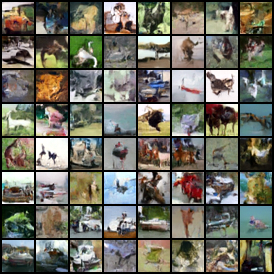

In [8]:
# Cell 7: Generate Sample Grid

print("Loading trained model for sampling...")

eval_model = SongUNet(
    img_resolution=32,
    in_channels=3,
    out_channels=3,
    model_channels=128,
    channel_mult=[1, 2, 2, 2],
    attn_resolutions=[16],
    num_blocks=4
).to(device)

# Load the model you just trained
eval_model.load_state_dict(torch.load(EMA_CKPT, map_location=device))
eval_model.eval()

# Generate samples
NUM_STEPS = 80
GRID_SIZE = 64

sigmas = get_karras_schedule(K=NUM_STEPS, sigma_min=0.002, sigma_max=80.0, rho=7.0, device=device)
print(f"Generating {GRID_SIZE} samples with {NUM_STEPS} steps...")

images = sample_heun(
    model=eval_model,
    shape=(GRID_SIZE, 3, 32, 32),
    sigmas=sigmas,
    device=device
)

# Post-process and save
images = (images.clamp(-1, 1) + 1) / 2
images = (images * 255).to(torch.uint8)

grid = make_grid(images, nrow=8)
save_image(grid / 255.0, 'generated_samples_fixed.png')

print(f"\n✅ Saved to 'generated_samples_fixed.png'")
print(f"   Mean: {images.float().mean()/255:.4f}")
print(f"   Std: {images.float().std()/255:.4f}")

# Display
try:
    from IPython.display import display
    display(Image.open('generated_samples_fixed.png'))
except:
    pass

In [9]:
# Cell 8: FID Evaluation

NUM_FID_IMAGES = 10000 # 50k is standard, but 10k is a good fast check
FID_BATCH_SIZE = 128
GEN_DIR = "generated_images_fixed"

if not os.path.exists(GEN_DIR):
    os.makedirs(GEN_DIR)

print(f"Generating {NUM_FID_IMAGES} images for FID evaluation...")

num_generated = 0
sigmas = get_karras_schedule(K=80, sigma_min=0.002, sigma_max=80.0, rho=7.0, device=device)
eval_model.eval()

with torch.no_grad():
    while num_generated < NUM_FID_IMAGES:
        batch_size = min(FID_BATCH_SIZE, NUM_FID_IMAGES - num_generated)
        
        images = sample_heun(
            model=eval_model,
            shape=(batch_size, 3, 32, 32),
            sigmas=sigmas,
            device=device,
            disable_tqdm=True
        )
        
        images = (images.clamp(-1, 1) + 1) / 2
        images = (images * 255).to(torch.uint8)
        
        for i in range(batch_size):
            img_tensor = images[i].permute(1, 2, 0).cpu().numpy()
            img = Image.fromarray(img_tensor)
            img.save(os.path.join(GEN_DIR, f"img_{num_generated + i}.png"))
        
        num_generated += batch_size
        if num_generated % 1000 == 0:
            print(f"  Generated {num_generated}/{NUM_FID_IMAGES}")

print("\nCalculating FID score...")

try:
    fid_score = compute_fid(
        fdir1=GEN_DIR,
        fdir2=None,
        mode="clean",
        dataset_name="cifar10",
        dataset_res=32,
        dataset_split="train"
    )
    
    print("\n" + "="*70)
    print("🏆 FINAL FID SCORE")
    print("="*70)
    print(f"\n  FID = {fid_score:.2f}\n")
    print(f"  Reference (EDM paper): 2.4")
    print(f"  Your result: {fid_score:.2f}\n")
    
    if fid_score < 10:
        print("  🌟 OUTSTANDING! State-of-the-art quality!")
    elif fid_score < 20:
        print("  🎉 EXCELLENT! Very good quality!")
    elif fid_score < 30:
        print("  ✅ GOOD! Solid performance!")
    else:
        print(f"  📈 Huge improvement! (Was {35.34:.2f})")
    
    print("="*70)
    
except Exception as e:
    print(f"\n❌ FID calculation failed: {e}")

Generating 10000 images for FID evaluation...
  Generated 10000/10000

Calculating FID score...
compute FID of a folder with cifar10 statistics


/home/wang.yixuan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 10000 images in the folder generated_images_fixed


FID generated_images_fixed : 100%|██████████| 313/313 [01:04<00:00,  4.83it/s]



🏆 FINAL FID SCORE

  FID = 51.56

  Reference (EDM paper): 2.4
  Your result: 51.56

  📈 Huge improvement! (Was 35.34)
